# NpyLinear

A simple Numpy based Linear Neural Network for classification tasks.

    This notebook shows the classification of mnist data using npyLinear.

In [1]:
import numpy as np
import os
import pandas as pd
from typing import Optional
from collections.abc import Iterator
from tqdm import tqdm
from model import Model
from npyLinear import (Adam, Adagrad, RMS_prop, Loss)
import matplotlib.pyplot as plt

In [2]:
class Dataset:

    def __init__(self, file: os.path):
        self.file = file

    def load_and_process(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        df = pd.read_csv(self.file)
        X = df.values
        train_len = int(0.8 * X.shape[0])
        indices = np.random.choice(X.shape[0], train_len, replace = False)
        Train = X[indices]
        Test = X[~np.isin(np.arange(len(X)), indices)]
        print("Size of Training data: ", f"{int(Train.shape[0])}, ", "Size of Testing data: ", int(Test.shape[0]))
        print()

        onehot_encode = lambda x: np.eye(10)[x]
        X_train = Train[:, 1:] / 255
        Y_train = Train[:, 0]
        Y_train = onehot_encode(Y_train)
        X_test = Test[:, 1:] / 255
        Y_test = Test[:, 0]
        Y_test = onehot_encode(Y_test)
        print("Training input shape: ", f"{X_train.shape},", "Training output shape: ", f"{Y_train.shape},", \
              "Testing input shape: ", f"{X_test.shape},", "Testing output shape: ", Y_test.shape)
        print()
        return X_train, Y_train, X_test, Y_test

In [3]:
def DataLoader(x: np.ndarray, y: np.ndarray, batch_size: int, shuffle: Optional[bool] = False) -> Iterator[np.ndarray, np.ndarray]:
    if shuffle:
        indices = np.random.permutation(x.shape[0])
        x = x[indices]
        y = y[indices]
    batch_skip = x.shape[0] // batch_size
    for i in range(0, x.shape[0], batch_skip):
        yield x[i : i + batch_skip, :], y[i : i + batch_skip, :]

def plot(Train: list, Test: list, title: str) -> None:
    if title == 'Loss':
        y_label = "loss"
    if title == 'Accuracy':
        y_label = "accuracy"
    plt.plot(Train, '-')
    plt.plot(Test, '-')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend(['Train', 'Validation'])
    plt.title(title)
    plt.show()

In [4]:
def train(Train: tuple, 
          Test: tuple, 
          model: object,
          epochs: int,
          loss_obj: object, 
          opt_obj: object, 
          batch_size: int, 
          filename: os.path,
          lambda_reg: Optional[float] = 0.0) -> tuple[list, list, list, list]:
    round = lambda x: np.round(x, 3)
    Train_Loss = []
    Train_Acc = []
    Val_Acc = []
    Val_Loss = []
    for epoch in range(1, epochs + 1):
        t_loss = []
        t_acc = []
        v_loss = []
        v_acc = []
        Train_Dl = DataLoader(Train[0], Train[1], batch_size, shuffle = True)
        Test_Dl = DataLoader(Test[0], Test[1], batch_size)
        for x, y in tqdm(Train_Dl, total = batch_size + 1, desc = f"Epoch {epoch}"):
            o, cache = model.forward(x)
            loss = loss_obj.cross_entropy_loss(y, o)
            t_loss.append(loss)
            dW, dB = loss_obj.backward(cache, y, model.act, x, lambda_reg = lambda_reg, bias_flag = model.bias_flag)
            W, B = opt_obj.step(epoch, dW, cache, dB)
            model.update(W, B)
            t_acc.append(model.accuracy(y, o))
        
        for x, y in Test_Dl:
            o, cache = model.forward(x)
            loss = loss_obj.cross_entropy_loss(y, o)
            v_loss.append(loss)
            v_acc.append(model.accuracy(y, o))
        train_loss = round(np.mean(np.array(t_loss)))
        val_loss = round(np.mean(np.array(v_loss)))
        train_acc = round(np.mean(np.array(t_acc)))
        val_acc = round(np.mean(np.array(v_acc)))
        print("Train loss - ", f"{train_loss},", "Train Accuracy - ", f"{train_acc},", \
              "Val loss - ", f"{val_loss},", "Val Accuracy - ", val_acc)
        Train_Loss.append(train_loss)
        Train_Acc.append(train_acc)
        Val_Acc.append(val_acc)
        Val_Loss.append(val_loss)
        print()

    model.save(filename)
    return Train_Loss, Train_Acc, Val_Loss, Val_Acc

In [5]:
def test(Test: tuple, model: object, plot_flag: bool = True) -> None:
    if plot_flag:
        fig, axes = plt.subplots(2, 5, figsize = (12, 5))
        axes = axes.flatten()
    X_test, Y_test = Test[0], Test[1]
    idx = np.random.randint(0, X_test.shape[0], size = 10)
    for i in range(10):
        out, _ = model.forward(X_test[idx[i], :].reshape(1, -1))
        f_str = f"True label: {int(np.argmax(Y_test, axis = 1)[idx[i]])}\nPredicted label: {int(np.argmax(out))}"
        if plot_flag:
            axes[i].imshow(X_test[idx[i], :].reshape(28, 28), cmap = 'gray')
            axes[i].axis('off') # hide the axes ticks
            axes[i].set_title(f_str, color = 'black', fontsize = 10)
        else:
            print(f_str)
            print()
    if plot_flag:
        plt.show()
        print("Figure is shown.")

In [ ]:
epochs = 5
batch_size = 256
lr = 1e-3
loss = Loss()
opt = Adam(0.9, 0.98, lr)
plot_show = False

filename = "model.pkl"

model = Model(bias = True)
dataset = Dataset("mnist_train.csv") # Dataset Ref: https://www.kaggle.com/competitions/digit-recognizer/overview
X_train, Y_train, X_test, Y_test = dataset.load_and_process()
Train = (X_train, Y_train)
Test = (X_test, Y_test)
train_loss, train_acc, val_loss, val_acc = train(Train, Test, model, epochs, loss, opt, batch_size, filename, lambda_reg = 0.4)

Size of Training data:  33600,  Size of Testing data:  8400

Training input shape:  (33600, 784), Training output shape:  (33600, 10), Testing input shape:  (8400, 784), Testing output shape:  (8400, 10)



Epoch 1: 100%|██████████| 257/257 [00:03<00:00, 82.29it/s]


Train loss -  0.429, Train Accuracy -  0.872, Val loss -  0.282, Val Accuracy -  0.916



Epoch 2: 100%|██████████| 257/257 [00:02<00:00, 88.71it/s]


Train loss -  0.186, Train Accuracy -  0.944, Val loss -  0.164, Val Accuracy -  0.953



Epoch 3: 100%|██████████| 257/257 [00:02<00:00, 88.44it/s]


Train loss -  0.131, Train Accuracy -  0.963, Val loss -  0.16, Val Accuracy -  0.952



Epoch 4: 100%|██████████| 257/257 [00:02<00:00, 89.81it/s]


Train loss -  0.114, Train Accuracy -  0.967, Val loss -  0.132, Val Accuracy -  0.963



Epoch 5: 100%|██████████| 257/257 [00:02<00:00, 88.97it/s]


Train loss -  0.103, Train Accuracy -  0.971, Val loss -  0.15, Val Accuracy -  0.959

All parameters are saved in model.pkl



In [7]:
print("Train Loss - ", f"{np.round(np.mean(np.array(train_loss)), 2)},", "Train Accuracy - ", f"{np.round(np.mean(np.array(train_acc)), 2)},", \
      "Val Loss - ", f"{np.round(np.mean(np.array(val_loss)), 2)},", "Val Accuracy - ", np.round(np.mean(np.array(val_acc)), 2))

Train Loss -  0.19, Train Accuracy -  0.94, Val Loss -  0.18, Val Accuracy -  0.95


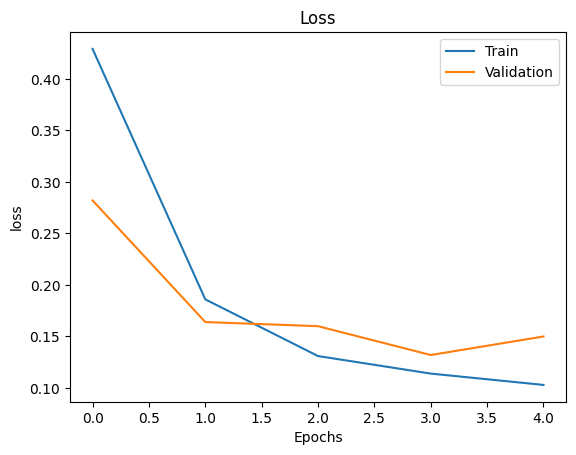

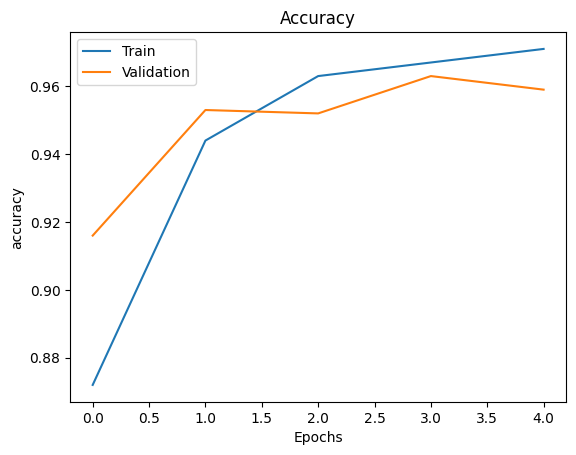

In [8]:
if plot_show:
    plot(train_loss, val_loss, "Loss")
    plot(train_acc, val_acc, "Accuracy")

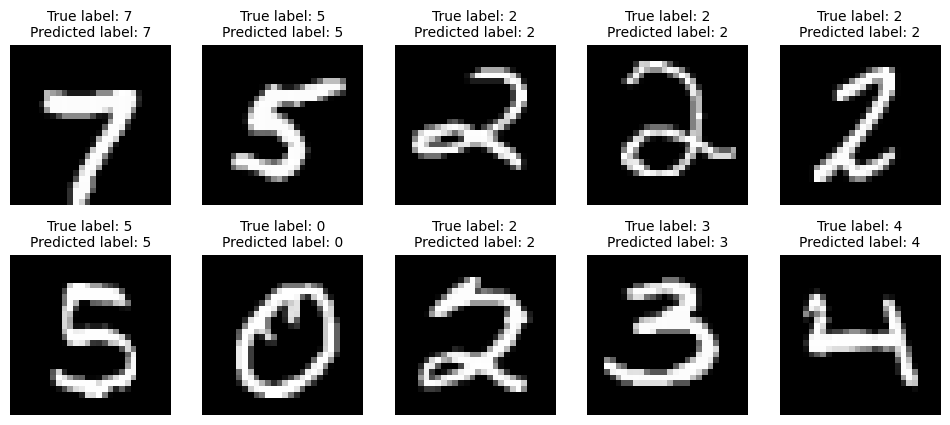

Figure is shown.


In [9]:
test(Test, model, plot_show)

### References:

1. [Blog](https://medium.com/towards-data-science/math-neural-network-from-scratch-in-python-d6da9f29ce65).
2. [Blog](https://medium.com/@waadlingaadil/learn-to-build-a-neural-network-from-scratch-yes-really-cac4ca457efc).
3. [Notebook](https://www.kaggle.com/code/scaomath/simple-neural-network-for-mnist-numpy-from-scratch/notebook).